In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd

#tensorflow
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.callbacks import EarlyStopping

#sklearn functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#matplotlib
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
working_directory = '/content/drive/MyDrive/Apziva/fake_audio_detection'

In [ ]:
real_voices_dir = os.path.join(working_directory, 'real_speeches')

In [ ]:
real_voices_dir

'/content/drive/MyDrive/Apziva/fake_audio_detection/real_speeches'

In [ ]:
fake_voices_dir = os.path.join(working_directory, 'fake_speeches')

In [ ]:
fake_voices_dir

'/content/drive/MyDrive/Apziva/fake_audio_detection/fake_speeches'

In [ ]:
import IPython.display as ipd

filepath = working_directory + '/fake_speeches/fake_1962.wav'


In [ ]:
print(filepath)

/content/drive/MyDrive/Apziva/fake_audio_detection/fake_speeches/fake_1962.wav


Extract numerical features from audio files

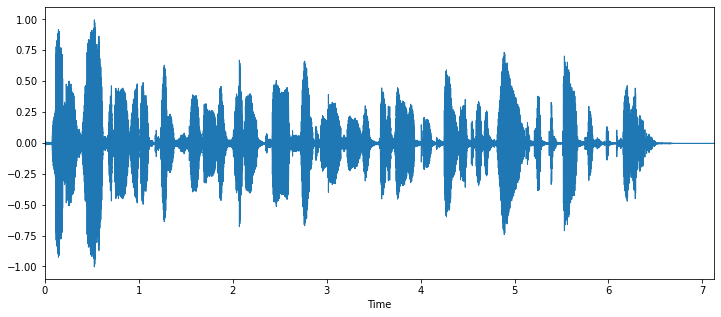

In [ ]:
data, sr = librosa.load(filepath)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)

In [ ]:
## use librosa to get the MFCC of the audio file

test_mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
print(test_mfcc.shape)
print(test_mfcc)

(40, 308)
[[-4.83015991e+02 -4.89592987e+02 -4.78134247e+02 ... -5.63669800e+02
  -5.63669800e+02 -5.63669800e+02]
 [ 1.00639244e+02  9.23628387e+01  1.04222389e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.04170151e+01  6.41645966e+01  6.77761765e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 2.52949905e+00  1.07364464e+00  7.20521927e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.26405668e+00  9.66791153e-01  5.62912226e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 9.77725267e-01  7.47048140e-01 -1.28558588e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [ ]:
np.mean(test_mfcc.T, axis=0)

array([-264.89377   ,   83.835045  ,    4.7160163 ,   12.997102  ,
        -16.839565  ,  -12.64328   ,  -19.738792  ,  -21.149925  ,
        -18.068068  ,    2.1513324 ,  -15.192237  ,   -9.401574  ,
        -14.316466  ,    4.3394365 ,  -10.674549  ,  -11.706846  ,
         -7.1114945 ,   -4.8852925 ,   -5.421181  ,  -13.126115  ,
         -4.2623935 ,   -7.2831326 ,  -11.520233  ,   -4.4411654 ,
         -6.602223  ,   -5.080266  ,   -4.055163  ,   -3.199945  ,
         -4.931222  ,   -3.3635967 ,   -5.1240187 ,   -4.492628  ,
         -3.5617628 ,   -0.34765708,   -1.1365846 ,    2.815568  ,
          2.7564607 ,    5.389313  ,    4.495444  ,    4.736498  ],
      dtype=float32)

In [ ]:
#extract mfcc, chroma, mel from the audio files
def get_feature_vectors(file_path):
    audio, sample_rate = librosa.load(file_path)
    mfcc = np.mean(librosa.feature.mfcc(y=audio, n_mfcc=40, sr=sample_rate).T, axis=0)
    stft = np.abs(librosa.stft(y=audio))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
    
    return mfcc, chroma, mel

In [ ]:


fake_list = os.listdir(fake_voices_dir)
real_list = os.listdir(real_voices_dir)

In [ ]:
fake_list[0]

'fake_1990.wav'

In [ ]:
cloned_features = []
real_features = []

for filename in fake_list:
    path = fake_voices_dir
    
    cloned_features.append(get_feature_vectors(os.path.join(path,filename)))
    
for filename in real_list:
    path = real_voices_dir
    
    real_features.append(get_feature_vectors(os.path.join(path,filename)))

In [ ]:
cloned_features = [np.concatenate((x[0], x[1], x[2]), axis=0) for x in cloned_features]
real_features = [np.concatenate((x[0], x[1], x[2]), axis=0) for x in real_features]

In [ ]:
print(np.array(cloned_features).shape)
print(np.array(real_features).shape)

(1968, 180)
(2004, 180)


In [ ]:
X = np.append(cloned_features, real_features, axis=0)
y = np.append(np.zeros(1968), np.ones(2004)).reshape((1968 + 2004), 1)

In [31]:
len(y)

3972

In [33]:
len(X)

3972

In [35]:
X[0]

array([-3.14476807e+02,  6.22242622e+01,  2.15249386e+01,  1.69255009e+01,
       -1.71537380e+01, -1.71419563e+01, -1.25827913e+01, -1.31723938e+01,
       -2.16539288e+01, -5.36488867e+00, -1.28112335e+01, -4.00755739e+00,
       -1.08559065e+01,  3.74103010e-01, -1.21750212e+01, -4.32800674e+00,
       -5.96869469e+00, -5.66685867e+00, -5.10903835e+00, -8.02637482e+00,
       -4.93491745e+00, -7.63972712e+00, -7.30667448e+00, -5.01519156e+00,
       -5.09721804e+00, -1.94915891e+00, -3.28846526e+00, -5.15404105e-01,
       -3.49252057e+00, -2.08861589e+00, -3.47700047e+00, -9.08296049e-01,
       -1.77319217e+00,  3.13111126e-01, -1.19975531e+00, -4.21889544e-01,
       -7.52007782e-01,  2.61571789e+00,  2.91533351e-01,  3.46435547e+00,
        5.89723587e-01,  5.27796566e-01,  4.62391615e-01,  4.61318523e-01,
        4.65378374e-01,  5.29851258e-01,  5.28980315e-01,  4.98948365e-01,
        5.26101291e-01,  5.52973986e-01,  5.15198410e-01,  5.50777674e-01,
        2.54992774e-04,  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= 10)

In [ ]:
print(f'X_train:{len(X_train)} val:{len(X_val)} test:{len(X_test)} Y_train:{len(y_train)} val:{len(y_val)} test:{len(y_test)}')

X_train:2859 val:318 test:795 Y_train:2859 val:318 test:795


In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [ ]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(180,)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               46336     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=[f1_metric])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
90/90 [==============================] - 3s 7ms/step - loss: 0.2379 - f1_metric: 0.9013 - val_loss: 0.0721 - val_f1_metric: 0.9700
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0633 - f1_metric: 0.9794 - val_loss: 0.0182 - val_f1_metric: 0.9966
Epoch 3/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0420 - f1_metric: 0.9818 - val_loss: 0.0051 - val_f1_metric: 1.0000
Epoch 4/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0366 - f1_metric: 0.9888 - val_loss: 0.0052 - val_f1_metric: 0.9971
Epoch 5/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0237 - f1_metric: 0.9920 - val_loss: 0.0142 - val_f1_metric: 0.9971
Epoch 6/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0277 - f1_metric: 0.9887 - val_loss: 0.0103 - val_f1_metric: 0.9971
Epoch 7/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0172 - f1_metric: 0.9947 - val_loss: 0.0212 - val_f1_metric: 0.9971

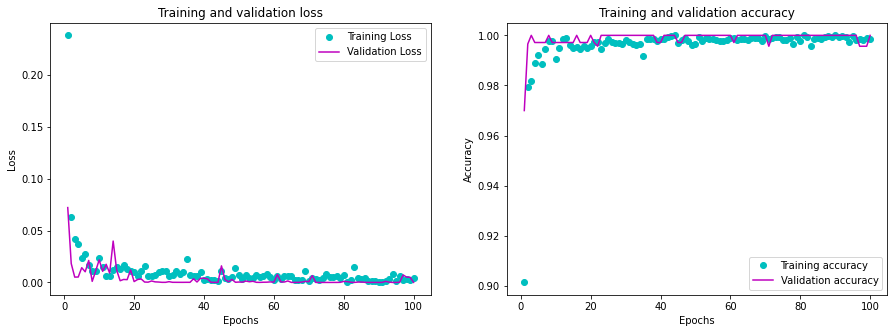

In [ ]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['f1_metric']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_f1_metric']
epochs=range(1,101)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

25/25 [==============================] - 0s 2ms/step - loss: 0.0010 - f1_metric: 0.9989


[0.0010073322337120771, 0.9988571405410767]

In [ ]:
preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

25/25 [==============================] - 0s 2ms/step
CONFUSION MATRIX ------------------
[[409   1]
 [  0 385]]

TEST METRICS ----------------------
Accuracy: 99.87421383647799%
Precision: 99.74093264248705%
Recall: 100.0%
F1-score: 99.8702983138781%
Specificity: 99.7560975609756%
